In [52]:
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

#import pmdarima as pm
#from pmdarima import auto_arima
from math import sqrt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor


import os
import warnings
from dataclasses import dataclass
from typing import List, Dict, Tuple


from IPython.display import Image

In [53]:
df_merged = pd.read_csv('merged_hydro_climate.csv')

In [54]:
df_merged.head(2)

,date_time,Source,current_mean,current_max,current_std,power_factor_mean,kwh_sum,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),...,Snowfall (mm),Snow Cover (%),date,time,consumer_device,data_user,voltage_value,is_red,is_blue,is_yellow
0,2023-06-03 13:00:00,consumer_device_3_data_user_11,0.0,0.0,0.0,0.0,0.0,7.199731,-2.448126,-0.034195,...,0.0,99.972656,2023-06-03,13:00:00,consumer_device_3,11,0.0,0,0,1
1,2023-06-03 13:00:00,consumer_device_3_data_user_3,0.0,0.0,0.0,0.0,0.0,7.199731,-2.448126,-0.034195,...,0.0,99.972656,2023-06-03,13:00:00,consumer_device_3,3,0.0,1,0,0


In [55]:
df_merged['date_time'] = pd.to_datetime(df_merged['date_time'])

In [56]:
df_merged.tail(2)

,date_time,Source,current_mean,current_max,current_std,power_factor_mean,kwh_sum,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),...,Snowfall (mm),Snow Cover (%),date,time,consumer_device,data_user,voltage_value,is_red,is_blue,is_yellow
3262639,2024-09-23 23:00:00,consumer_device_31_data_user_6,0.000000,0.00,0.000000,0.0000,0.000000,4.977533,0.843713,0.055191,...,0.0,0.0,2024-09-23,23:00:00,consumer_device_31,6,0.000,0,1,0
3262640,2024-09-23 23:00:00,consumer_device_12_data_user_3,0.943333,1.01,0.055814,0.3675,0.065902,4.977533,0.843713,0.055191,...,0.0,0.0,2024-09-23,23:00:00,consumer_device_12,3,185.975,0,0,1


In [57]:
df_merged.columns

Index(['date_time', 'Source', 'current_mean', 'current_max', 'current_std',
       'power_factor_mean', 'kwh_sum', 'Temperature (°C)',
       'Dewpoint Temperature (°C)', 'U Wind Component (m/s)',
       'V Wind Component (m/s)', 'Total Precipitation (mm)', 'Snowfall (mm)',
       'Snow Cover (%)', 'date', 'time', 'consumer_device', 'data_user',
       'voltage_value', 'is_red', 'is_blue', 'is_yellow'],
      dtype='object')

In [58]:
df_power = pd.read_csv('consumer_devices.csv')

In [59]:
df_power.tail(2)

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x
39147557,2024-09-14 05:30:00,0.0,0.0,0.0,0.0,consumer_device_9_data_user_9,NaN,NaN,1,9
39147558,2024-09-14 05:35:00,0.0,0.0,0.0,0.0,consumer_device_9_data_user_9,NaN,NaN,1,9


In [60]:
df_power.columns

Index(['date_time', 'v_red', 'current', 'power_factor', 'kwh', 'Source',
       'v_blue', 'v_yellow', 'consumer_device_9', 'consumer_device_x'],
      dtype='object')

In [61]:
# Ensure datetime is in proper format
df_power['date_time'] = pd.to_datetime(df_power['date_time'])

In [62]:
# Count how many phase columns are non-null per row
df_power['active_phases'] = df_power[['v_red', 'v_blue', 'v_yellow']].notnull().sum(axis=1)

# Check distribution of active phases
phase_counts = df_power['active_phases'].value_counts().sort_index()
print("Number of active phases per row:")
print(phase_counts)

# Count rows where none of the phases are active
num_inactive = (df_power['active_phases'] == 0).sum()
print(f"\nNumber of rows with no active phases (all NaN): {num_inactive}")

# Check if single-phase data
if phase_counts.index.max() == 1:
    print("\nConfirmed: Each row has exactly one active phase (single-phase recording).")
else:
    print("\nSome rows have more than one phase active at the same time.")

# Check rows with more than 1 active phase
multi_phase_rows = df_power[df_power['active_phases'] > 1]
if not multi_phase_rows.empty:
    print("\nRows with multiple active phases detected:")
    print(multi_phase_rows[['date_time','v_red','v_blue','v_yellow']].head(10))

# Check rows with zero active phases
inactive_rows = df_power[df_power['active_phases'] == 0]
if not inactive_rows.empty:
    print("\nRows with no active phases (all NaN):")
    print(inactive_rows[['date_time','v_red','v_blue','v_yellow']].head(10))


Number of active phases per row:
active_phases
1    39147559
Name: count, dtype: int64

Number of rows with no active phases (all NaN): 0

Confirmed: Each row has exactly one active phase (single-phase recording).


In [63]:
df_power = df_power.copy()

# Datetime to sort
df_power = df_power.sort_values('date_time').reset_index(drop=True)

# Time in hours
df_power['time_delta_hours'] = df_power['date_time'].diff().dt.total_seconds() / 3600

# Safely set the first row
df_power.loc[0, 'time_delta_hours'] = 5 / 60  # 0.08333 hours

# Extreme deltas
df_power['time_delta_hours'] = df_power['time_delta_hours'].clip(lower=0.001, upper=0.2)

# Estimated kWh for each interval
df_power['kwh_estimated'] = (df_power['active_phases'] * df_power['current'] * df_power['power_factor'] * df_power['time_delta_hours']) / 1000

# Residuals
df_power['residual'] = df_power['kwh'] - df_power['kwh_estimated']

# Check matches
tolerance = 0.01
df_power['match'] = np.isclose(df_power['kwh'], df_power['kwh_estimated'], atol=tolerance)

num_correct = df_power['match'].sum()
num_incorrect = (~df_power['match']).sum()

print(f"Number of rows where formula is correct: {num_correct}")
print(f"Number of rows where formula is incorrect: {num_incorrect}")


Number of rows where formula is correct: 38131214
Number of rows where formula is incorrect: 1016345


Number of active phases per row:
active_phases
1    39147559
 Number of rows where formula is correct: 38132014
 Number of rows where formula is incorrect: 1015545

Active rows: 39,147,559 (rows with at least one phase voltage)
Correct kWh estimates: 38,132,014 (~97.4%)
Incorrect kWh estimates: 1,015,545 (~2.6%)

In [64]:
# Define a tolerance for matching (e.g., 0.01 kWh)
tolerance = 0.01

# Count rows where the estimated kWh matches the actual kWh within the tolerance
df_power['match'] = np.isclose(df_power['kwh'], df_power['kwh_estimated'], atol=tolerance)

# Number of correct and incorrect rows
num_correct = df_power['match'].sum()
num_incorrect = (~df_power['match']).sum()

print(f"Number of rows where formula is correct: {num_correct}")
print(f"Number of rows where formula is incorrect: {num_incorrect}")


Number of rows where formula is correct: 38131214
Number of rows where formula is incorrect: 1016345


Moved from hourly to Daily forecasting

In [65]:
df_daily_merged = pd.read_csv('daily_merged_hydro_climate.csv')

In [66]:
df_daily_merged.head(5)

,date,Source,current_mean,current_max,current_std,power_factor_mean,kwh_sum,Temperature (°C)_mean,Temperature (°C)_min,Temperature (°C)_max,...,V Wind Component (m/s)_mean,Total Precipitation (mm)_sum,Snowfall (mm)_sum,Snow Cover (%)_mean,consumer_device,data_user,voltage_value,is_red,is_blue,is_yellow
0,2023-06-03,consumer_device_3_data_user_9,0.000576,0.08,0.006786,0.005324,0.000922,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,9,1.344820,0,0,1
1,2023-06-03,consumer_device_3_data_user_4,0.000647,0.09,0.007634,0.005468,0.001066,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,4,1.344820,0,1,0
2,2023-06-03,consumer_device_3_data_user_3,0.000719,0.10,0.008482,0.005468,0.001183,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,3,1.343381,1,0,0
3,2023-06-03,consumer_device_3_data_user_11,0.000647,0.09,0.007634,0.005180,0.001009,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,11,1.344820,0,0,1
4,2023-06-03,consumer_device_3_data_user_5,0.000647,0.09,0.007634,0.005612,0.001094,1.86028,-1.513861,7.199731,...,-0.657726,0.004557,0.0,99.972656,consumer_device_3,5,1.344820,0,0,1


In [67]:
df_daily_merged.columns

Index(['date', 'Source', 'current_mean', 'current_max', 'current_std',
       'power_factor_mean', 'kwh_sum', 'Temperature (°C)_mean',
       'Temperature (°C)_min', 'Temperature (°C)_max',
       'Dewpoint Temperature (°C)_mean', 'Dewpoint Temperature (°C)_min',
       'Dewpoint Temperature (°C)_max', 'U Wind Component (m/s)_mean',
       'V Wind Component (m/s)_mean', 'Total Precipitation (mm)_sum',
       'Snowfall (mm)_sum', 'Snow Cover (%)_mean', 'consumer_device',
       'data_user', 'voltage_value', 'is_red', 'is_blue', 'is_yellow'],
      dtype='object')

In [68]:
df_daily_merged['date'].dtype

dtype('O')

In [69]:
df_daily_merged['date'] = pd.to_datetime(df_daily_merged['date'])

In [70]:
# Check min/max date
print("Dataset covers:", df_daily_merged.index.min(), "to", df_daily_merged.index.max())

# Create full expected daily date range
full_range = pd.date_range(start="2023-06-03", end="2024-09-23", freq="D")

# Compare with your actual dataset index
missing_dates = full_range.difference(df_daily_merged.index)

print("Number of missing days:", len(missing_dates))
print("Missing days:", missing_dates[:20])  # show first 20 if many

Dataset covers: 0 to 136408
Number of missing days: 479
Missing days: DatetimeIndex(['2023-06-03', '2023-06-04', '2023-06-05', '2023-06-06',
               '2023-06-07', '2023-06-08', '2023-06-09', '2023-06-10',
               '2023-06-11', '2023-06-12', '2023-06-13', '2023-06-14',
               '2023-06-15', '2023-06-16', '2023-06-17', '2023-06-18',
               '2023-06-19', '2023-06-20', '2023-06-21', '2023-06-22'],
              dtype='datetime64[ns]', freq='D')


In [71]:
# Loop through all consumers
sources = df_daily_merged['Source'].unique()
for source in sources:
    df_source = df_daily_merged[df_daily_merged['Source'] == source].copy()
    df_source = df_source.sort_index()
    
    # Create complete daily index
    full_idx = pd.date_range(df_source.index.min(), df_source.index.max(), freq='D')
    df_source = df_source.reindex(full_idx)
    
    # Count missing days
    missing_days = df_source['kwh_sum'].isna().sum()
    if missing_days > 0:
        print(f"Consumer {source} has {missing_days} missing days.")
    else:
        print(f"Consumer {source} has no missing days.")


Consumer consumer_device_3_data_user_9 has 1 missing days.
Consumer consumer_device_3_data_user_4 has 1 missing days.
Consumer consumer_device_3_data_user_3 has 1 missing days.
Consumer consumer_device_3_data_user_11 has 1 missing days.
Consumer consumer_device_3_data_user_5 has 1 missing days.
Consumer consumer_device_3_data_user_7 has 1 missing days.
Consumer consumer_device_3_data_user_1 has 1 missing days.
Consumer consumer_device_3_data_user_10 has 1 missing days.
Consumer consumer_device_3_data_user_6 has 1 missing days.
Consumer consumer_device_3_data_user_2 has 1 missing days.
Consumer consumer_device_3_data_user_8 has 1 missing days.
Consumer consumer_device_16_data_user_9 has 1 missing days.
Consumer consumer_device_16_data_user_18 has 1 missing days.
Consumer consumer_device_16_data_user_7 has 1 missing days.
Consumer consumer_device_16_data_user_1 has 1 missing days.
Consumer consumer_device_16_data_user_8 has 1 missing days.
Consumer consumer_device_16_data_user_3 has 1 mi

In [73]:
'''# Full daily range for the dataset
full_range = pd.date_range(start="2023-06-03", end="2024-09-23", freq="D")

# Identify climate features
climate_cols = [
    'Temperature (°C)_mean','Temperature (°C)_min','Temperature (°C)_max',
    'Dewpoint Temperature (°C)_mean','Dewpoint Temperature (°C)_min','Dewpoint Temperature (°C)_max',
    'U Wind Component (m/s)_mean','V Wind Component (m/s)_mean',
    'Total Precipitation (mm)_sum','Snowfall (mm)_sum','Snow Cover (%)_mean'
]

def prepare_consumer_data(df, source_name):
    df_source = df[df["Source"] == source_name].copy()
    
    # Reindex on full_range with MultiIndex (Source, date)
    df_source = df_source.reindex(full_range).reset_index()
    df_source = df_source.rename(columns={"index": "date"})
    df_source["Source"] = source_name
    
    # Fill missing target
    df_source["kwh_sum"] = df_source["kwh_sum"].ffill()  # or .fillna(0)
    
    # Fill climate variables
    df_source[climate_cols] = df_source[climate_cols].interpolate().ffill()
    
    return df_source.set_index("date")

# Apply to all sources
sources = df_daily_merged["Source"].unique()
df_cleaned = pd.concat([prepare_consumer_data(df_daily_merged, s) for s in sources])

print("Preprocessing complete. Shape:", df_cleaned.shape)
print("Number of sources:", len(sources))
print("Expected rows per source:", len(full_range))'''

'# Full daily range for the dataset\nfull_range = pd.date_range(start="2023-06-03", end="2024-09-23", freq="D")\n\n# Identify climate features\nclimate_cols = [\n    \'Temperature (°C)_mean\',\'Temperature (°C)_min\',\'Temperature (°C)_max\',\n    \'Dewpoint Temperature (°C)_mean\',\'Dewpoint Temperature (°C)_min\',\'Dewpoint Temperature (°C)_max\',\n    \'U Wind Component (m/s)_mean\',\'V Wind Component (m/s)_mean\',\n    \'Total Precipitation (mm)_sum\',\'Snowfall (mm)_sum\',\'Snow Cover (%)_mean\'\n]\n\ndef prepare_consumer_data(df, source_name):\n    df_source = df[df["Source"] == source_name].copy()\n\n    # Reindex on full_range with MultiIndex (Source, date)\n    df_source = df_source.reindex(full_range).reset_index()\n    df_source = df_source.rename(columns={"index": "date"})\n    df_source["Source"] = source_name\n\n    # Fill missing target\n    df_source["kwh_sum"] = df_source["kwh_sum"].ffill()  # or .fillna(0)\n\n    # Fill climate variables\n    df_source[climate_cols] =

Devices data range: 2023-06-03 12:25:00 to 2024-09-23 23:55:00. 
Climate data range: 2023-06-03 13:00:00 to 2024-10-25 00:00:00. 
Overlap range: 2023-06-03 13:00:00 to 2024-09-23 23:55:00.

Feature Importance / Correlation Check from Dataset

In [74]:
# Aggregate by date (sum kWh, mean climate/device values)
df_agg = df.groupby('date').agg({
    'kwh_sum':'sum',
    'current_mean':'mean',
    'current_max':'max',
    'current_std':'mean',
    'power_factor_mean':'mean',
    'Temperature (°C)_mean':'mean',
    'Temperature (°C)_min':'min',
    'Temperature (°C)_max':'max',
    'Dewpoint Temperature (°C)_mean':'mean',
    'Dewpoint Temperature (°C)_min':'min',
    'Dewpoint Temperature (°C)_max':'max',
    'U Wind Component (m/s)_mean':'mean',
    'V Wind Component (m/s)_mean':'mean',
    'Total Precipitation (mm)_sum':'sum',
    'Snowfall (mm)_sum':'sum',
    'Snow Cover (%)_mean':'mean',
    'voltage_value':'mean',
    'is_red':'sum',
    'is_blue':'sum',
    'is_yellow':'sum',
    'consumer_device':'nunique',
    'data_user':'nunique'
}).rename(columns={'consumer_device':'consumer_count','data_user':'user_count'}).reset_index()

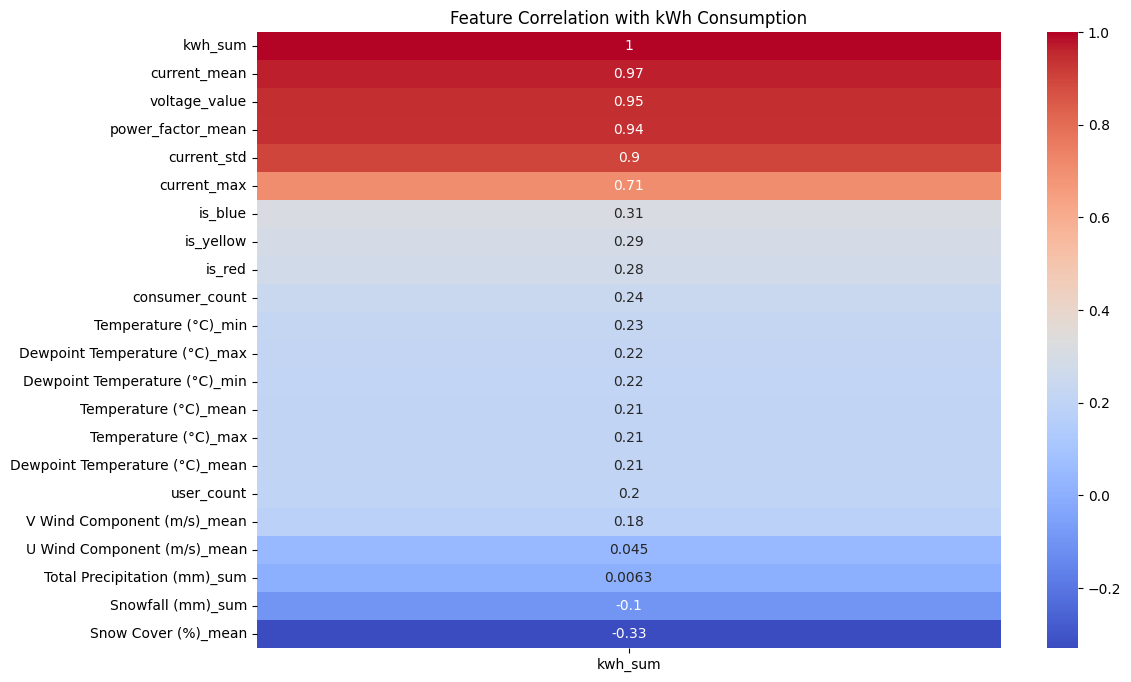

In [75]:
# Correlation heatmap
plt.figure(figsize=(12,8))
corr = df_agg.drop(columns=['date']).corr()
sns.heatmap(corr[['kwh_sum']].sort_values(by='kwh_sum', ascending=False), annot=True, cmap="coolwarm")
plt.title("Feature Correlation with kWh Consumption")
plt.show()


In [76]:
from sklearn.ensemble import RandomForestRegressor

X = df_agg.drop(['date','kwh_sum'], axis=1)  # all numeric
y = df_agg['kwh_sum']

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)


RandomForestRegressor(n_estimators=200, random_state=42)

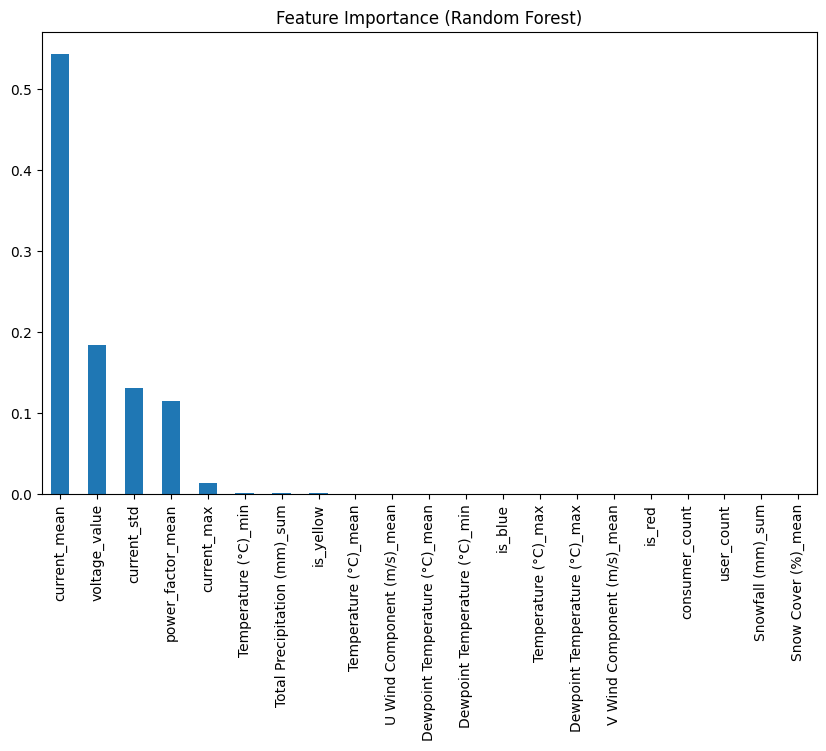

In [77]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances.plot(kind='bar')
plt.title("Feature Importance (Random Forest)")
plt.show()

Feature Importance Using Random Forest

Forecasting for an extra month with climate features.

In [78]:
df_climate = pd.read_csv('climate_data.csv')

In [79]:
df_climate.head(5)

,Date Time,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),i,j,...,q,r,s,t,u,v,w,x,y,z
0,2023-06-03T13:00:00,7.199731,-2.448126,-0.034195,0.060989,0.000377,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-06-03T14:00:00,6.000620,-2.597540,-0.080688,0.018585,0.000398,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-06-03T15:00:00,4.789972,-2.696951,0.057449,-0.352020,0.000418,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-06-03T16:00:00,3.158746,-2.879324,0.051529,-0.608948,0.000420,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-06-03T17:00:00,1.671426,-3.255606,0.056137,-0.739838,0.000420,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
df_climate = df_climate.drop(columns=['i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'])

In [81]:
df_climate.columns

Index(['Date Time', 'Temperature (°C)', 'Dewpoint Temperature (°C)',
       'U Wind Component (m/s)', 'V Wind Component (m/s)',
       'Total Precipitation (mm)', 'Snowfall (mm)', 'Snow Cover (%)'],
      dtype='object')

In [82]:
df_climate['Date Time'] = pd.to_datetime(df_climate['Date Time'])


In [ ]:
'''# Set Date Time as index
df_climate.set_index('Date Time', inplace=True)
# Reset index and rename to Date
df_climate = df_climate.reset_index().rename(columns={'Date Time': 'date'})'''

In [ ]:
'''# Define the date range for extra month
start_date = '2024-09-24'
end_date = '2024-10-25'

# Filter the dataset
df_extra_weather = df_climate[(df_climate['date'] >= start_date) & (df_climate['date'] <= end_date)]

# Save to CSV
df_extra_weather.to_csv('df_extra_weather.csv', index=False)

print(df_extra_weather.head(2))'''

In [83]:
# Set Date Time as index
df_climate.set_index('Date Time', inplace=True)

# Define aggregation rules
agg_dict = {
    'Temperature (°C)': ['mean', 'min', 'max'],
    'Dewpoint Temperature (°C)': ['mean', 'min', 'max'],
    'U Wind Component (m/s)': 'mean',
    'V Wind Component (m/s)': 'mean',
    'Total Precipitation (mm)': 'sum',
    'Snowfall (mm)': 'sum',
    'Snow Cover (%)': 'mean'
}

# Aggregate by day
df_daily_climate = df_climate.resample('D').agg(agg_dict)

# Flatten MultiIndex columns
df_daily_climate.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_daily_climate.columns]

# Reset index and rename to Date
df_daily_climate = df_daily_climate.reset_index().rename(columns={'Date Time': 'date'})

print(df_daily_climate.head())


        date  Temperature (°C)_mean  Temperature (°C)_min   
0 2023-06-03               1.860280             -1.513861  \
1 2023-06-04               3.992740             -3.258566   
2 2023-06-05               4.794523             -4.962714   
3 2023-06-06               6.304390              0.213861   
4 2023-06-07               7.003922              1.434000   

   Temperature (°C)_max  Dewpoint Temperature (°C)_mean   
0              7.199731                       -3.348664  \
1              9.100580                       -1.905203   
2             10.031442                       -3.781657   
3             11.149500                       -4.670615   
4             12.092218                       -3.965763   

   Dewpoint Temperature (°C)_min  Dewpoint Temperature (°C)_max   
0                      -4.697501                      -2.448126  \
1                      -5.135535                       0.460703   
2                      -6.197546                      -1.211890   
3         

In [84]:
df_daily_climate.tail(2)

,date,Temperature (°C)_mean,Temperature (°C)_min,Temperature (°C)_max,Dewpoint Temperature (°C)_mean,Dewpoint Temperature (°C)_min,Dewpoint Temperature (°C)_max,U Wind Component (m/s)_mean,V Wind Component (m/s)_mean,Total Precipitation (mm)_sum,Snowfall (mm)_sum,Snow Cover (%)_mean
509,2024-10-24,-0.349515,-6.864859,5.951120,-1.964442,-8.32897,2.333704,0.045428,-0.506269,0.010772,0.004634,9.877035
510,2024-10-25,-7.224661,-7.224661,-7.224661,-8.735220,-8.73522,-8.735220,-0.076797,-1.251801,0.000399,0.000131,7.875000


In [85]:
# Define the date range for extra month
start_date = '2024-09-24'
end_date = '2024-10-25'

# Filter the dataset
df_extra_month = df_daily_climate[(df_daily_climate['date'] >= start_date) & (df_daily_climate['date'] <= end_date)]

# Save to CSV
df_extra_month.to_csv('df_climate_extra_month.csv', index=False)

print(df_extra_month.head())

          date  Temperature (°C)_mean  Temperature (°C)_min   
479 2024-09-24              13.899341              6.350473  \
480 2024-09-25              12.475849              7.036218   
481 2024-09-26               9.702699              6.334360   
482 2024-09-27               6.806661              4.086908   
483 2024-09-28               6.399286              2.196313   

     Temperature (°C)_max  Dewpoint Temperature (°C)_mean   
479             21.140833                        2.104299  \
480             17.764078                        5.623678   
481             13.710367                        7.375160   
482              9.612451                        5.905107   
483             10.177530                        2.932036   

     Dewpoint Temperature (°C)_min  Dewpoint Temperature (°C)_max   
479                      -3.480551                       8.100595  \
480                      -2.619650                       8.845438   
481                       5.537805             

In [86]:
df_extra_month.columns

Index(['date', 'Temperature (°C)_mean', 'Temperature (°C)_min',
       'Temperature (°C)_max', 'Dewpoint Temperature (°C)_mean',
       'Dewpoint Temperature (°C)_min', 'Dewpoint Temperature (°C)_max',
       'U Wind Component (m/s)_mean', 'V Wind Component (m/s)_mean',
       'Total Precipitation (mm)_sum', 'Snowfall (mm)_sum',
       'Snow Cover (%)_mean'],
      dtype='object')

In [87]:
df_daily_merged = pd.read_csv('daily_merged_hydro_climate.csv')

In [88]:
df_daily_merged.columns

Index(['date', 'Source', 'current_mean', 'current_max', 'current_std',
       'power_factor_mean', 'kwh_sum', 'Temperature (°C)_mean',
       'Temperature (°C)_min', 'Temperature (°C)_max',
       'Dewpoint Temperature (°C)_mean', 'Dewpoint Temperature (°C)_min',
       'Dewpoint Temperature (°C)_max', 'U Wind Component (m/s)_mean',
       'V Wind Component (m/s)_mean', 'Total Precipitation (mm)_sum',
       'Snowfall (mm)_sum', 'Snow Cover (%)_mean', 'consumer_device',
       'data_user', 'voltage_value', 'is_red', 'is_blue', 'is_yellow'],
      dtype='object')

In [89]:
df_daily_merged['date'] = pd.to_datetime(df_daily_merged['date'])

First Prophet Model.

In [34]:
df = df_daily_merged.copy()
df = df.sort_values('date')

target = 'kwh_sum'
climate_features = [
       'Temperature (°C)_mean', 'Temperature (°C)_min',
       'Temperature (°C)_max', 'Dewpoint Temperature (°C)_mean',
       'Dewpoint Temperature (°C)_min', 'Dewpoint Temperature (°C)_max',
       'U Wind Component (m/s)_mean', 'V Wind Component (m/s)_mean',
       'Total Precipitation (mm)_sum', 'Snowfall (mm)_sum',
       'Snow Cover (%)_mean'
]

# Lag and rolling features
df['kwh_sum_lag1'] = df[target].shift(1)
df['kwh_sum_lag7'] = df[target].shift(7)
df['kwh_sum_roll7'] = df[target].rolling(7).mean()
df = df.dropna()


# Drop NaN only for training/testing
df_train_test = df.dropna().reset_index(drop=True)

# Prophet format
prophet_df = df_train_test.rename(columns={'date':'ds', target:'y'})

# Train-Test split
train = prophet_df[prophet_df['ds'] <= '2024-08-23']
test  = prophet_df[(prophet_df['ds'] >= '2024-08-24') & (prophet_df['ds'] <= '2024-09-23')]

# Prophet model
m = Prophet()

# Add regressors
for col in climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']:
    m.add_regressor(col)

# Fit
m.fit(train[['ds','y'] + climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']])
#save train features
train_features = train[['ds','y'] + climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']]
train_features.to_csv('models/prophet_train_features.csv', index=False)

#save the model
import pickle
with open('models/prophet_model.pkl', 'wb') as f:
    pickle.dump(m, f)

# Predict test
forecast_test = m.predict(test[['ds'] + climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']])
#save test features
test_features = test[['ds','y'] + climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']]
test_features.to_csv('models/prophet_test_features.csv', index=False)

rmse = sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
print(f"Test RMSE: {rmse:.2f}")


19:10:23 - cmdstanpy - INFO - Chain [1] start processing
19:10:25 - cmdstanpy - INFO - Chain [1] done processing


Test RMSE: 8.64


In [35]:
df['kwh_sum'].describe()

count    136402.000000
mean          0.603745
std           3.756707
min           0.000000
25%           0.000000
50%           0.000000
75%           0.005574
max         122.522994
Name: kwh_sum, dtype: float64

2nd Prophet Model with higher RMSE and Zindi Score.

21:39:04 - cmdstanpy - INFO - Chain [1] start processing
21:39:09 - cmdstanpy - INFO - Chain [1] done processing


Test RMSE: 4.41


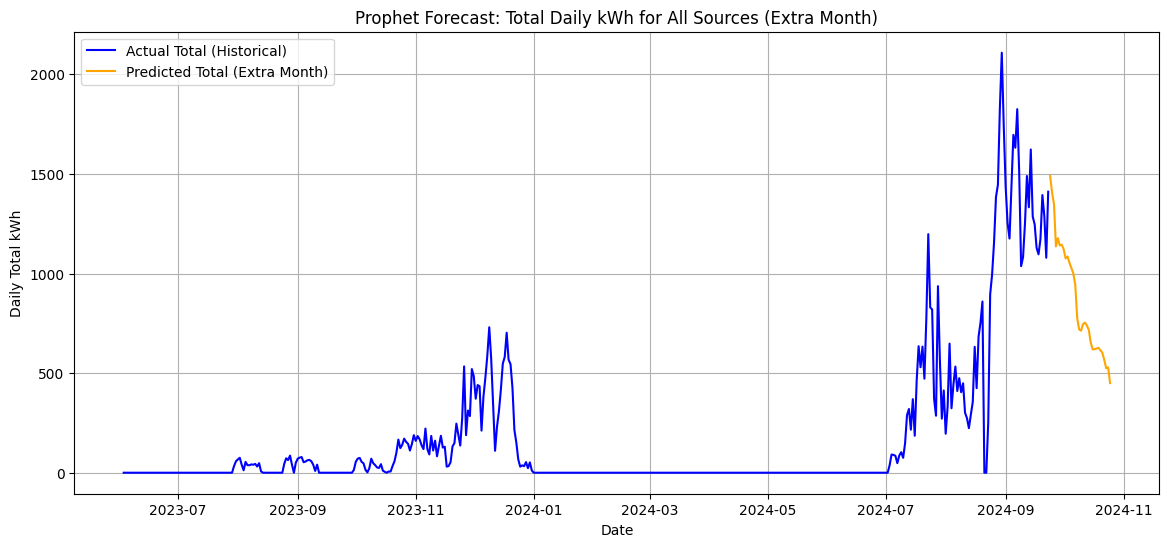

In [48]:
import pandas as pd
import numpy as np
from prophet import Prophet
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Prepare dataset ---
df_daily_merged['date'] = pd.to_datetime(df_daily_merged['date'])
df = df_daily_merged.copy()
df = df.sort_values('date')

target = 'kwh_sum'
climate_features = [
    'Temperature (°C)_mean', 'Temperature (°C)_min', 'Temperature (°C)_max',
    'Dewpoint Temperature (°C)_mean', 'Dewpoint Temperature (°C)_min', 'Dewpoint Temperature (°C)_max',
    'U Wind Component (m/s)_mean', 'V Wind Component (m/s)_mean',
    'Total Precipitation (mm)_sum', 'Snowfall (mm)_sum', 'Snow Cover (%)_mean'
]

# --- Lag features ---
df['kwh_sum_lag1'] = df.groupby('Source')[target].shift(1)
df['kwh_sum_lag7'] = df.groupby('Source')[target].shift(7)
df['kwh_sum_roll7'] = df.groupby('Source')[target].shift(1).rolling(7).mean()
df = df.dropna().reset_index(drop=True)

# --- Prophet format ---
prophet_df = df.rename(columns={'date':'ds', target:'y'})

# --- Train/Test split ---
train = prophet_df[prophet_df['ds'] <= '2024-08-23']
test  = prophet_df[(prophet_df['ds'] >= '2024-08-24') & (prophet_df['ds'] <= '2024-09-23')]

# --- Train Prophet model on all sources combined ---
m = Prophet()
for col in climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']:
    m.add_regressor(col)

m.fit(train[['ds','y'] + climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']])

# --- Predict test ---
forecast_test = m.predict(test[['ds'] + climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']])

# --- RMSE ---
rmse = sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
print(f"Test RMSE: {rmse:.2f}")

# --- Extra month forecast (recursive, aggregated total) ---
df_extra_month = df_extra_month.copy()
df_extra_month['ds'] = pd.to_datetime(df_extra_month['date'])

all_sources = df_daily_merged['Source'].unique()
daily_total = pd.DataFrame({'ds': df_extra_month['ds'].unique()})
daily_total.set_index('ds', inplace=True)
daily_total['pred_total_kwh'] = 0

for src in all_sources:
    # Historical data per source
    df_source = df_daily_merged[df_daily_merged['Source']==src].copy()
    df_source = df_source.sort_values('date').reset_index(drop=True)
    
    # Lag history (last 30 days)
    lag_hist = df_source.tail(30).copy().reset_index(drop=True)
    
    # Predict extra month recursively
    preds = []
    for _, row in df_extra_month.iterrows():
        r = row.copy()
        r['kwh_sum_lag1'] = lag_hist[target].iloc[-1]
        r['kwh_sum_lag7'] = lag_hist[target].iloc[-7] if len(lag_hist)>=7 else lag_hist[target].mean()
        r['kwh_sum_roll7'] = lag_hist[target].iloc[-7:].mean() if len(lag_hist)>=7 else lag_hist[target].mean()
        
        # Fill missing climate features
        for col in climate_features:
            if pd.isna(r[col]):
                r[col] = 0
        
        # Predict
        predictors = ['ds'] + climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']
        r['pred_kwh'] = m.predict(pd.DataFrame([r])[predictors])['yhat'].values[0]
        
        # Update lag history
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{target: r['pred_kwh']}])], ignore_index=True)
        preds.append(r['pred_kwh'])
    
    # Aggregate daily total across sources
    daily_total['pred_total_kwh'] += preds

daily_total = daily_total.reset_index()

# --- Plot ---
plt.figure(figsize=(14,6))
# Historical actual total per day
historical_total = df_daily_merged.groupby('date')[target].sum().reset_index()
plt.plot(historical_total['date'], historical_total[target], label='Actual Total (Historical)', color='blue')
# Extra month predicted total
plt.plot(daily_total['ds'], daily_total['pred_total_kwh'], label='Predicted Total (Extra Month)', color='orange')
plt.xlabel('Date')
plt.ylabel('Daily Total kWh')
plt.title('Prophet Forecast: Total Daily kWh for All Sources (Extra Month)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from math import sqrt
from sklearn.metrics import mean_squared_error

# --- Prepare dataset ---
df_daily_merged['date'] = pd.to_datetime(df_daily_merged['date'])
df = df_daily_merged.copy()
df = df.sort_values('date')

target = 'kwh_sum'
climate_features = [
    'Temperature (°C)_mean', 'Temperature (°C)_min', 'Temperature (°C)_max',
    'Dewpoint Temperature (°C)_mean', 'Dewpoint Temperature (°C)_min', 'Dewpoint Temperature (°C)_max',
    'U Wind Component (m/s)_mean', 'V Wind Component (m/s)_mean',
    'Total Precipitation (mm)_sum', 'Snowfall (mm)_sum', 'Snow Cover (%)_mean'
]

# --- Lag features ---
df['kwh_sum_lag1'] = df.groupby('Source')[target].shift(1)
df['kwh_sum_lag7'] = df.groupby('Source')[target].shift(7)
df['kwh_sum_roll7'] = df.groupby('Source')[target].shift(1).rolling(7).mean()
df = df.dropna().reset_index(drop=True)

# --- Prophet format ---
prophet_df = df.rename(columns={'date':'ds', target:'y'})

# --- Train/Test split ---
train = prophet_df[prophet_df['ds'] <= '2024-08-23']
test  = prophet_df[(prophet_df['ds'] >= '2024-08-24') & (prophet_df['ds'] <= '2024-09-23')]

# --- Train Prophet model on all sources combined ---
m = Prophet()
for col in climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']:
    m.add_regressor(col)

m.fit(train[['ds','y'] + climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']])

# --- Predict on test ---
forecast_test = m.predict(test[['ds'] + climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']])

# --- RMSE ---
rmse = sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
print(f"Test RMSE: {rmse:.2f}")

# --- Extra month forecast per source for Zindi submission ---
df_extra_month['ds'] = pd.to_datetime(df_extra_month['date'])
all_sources = df_daily_merged['Source'].unique()
submission_rows = []

for source in all_sources:
    # Historical data per source
    df_source = df_daily_merged[df_daily_merged['Source']==source].copy()
    df_source = df_source.sort_values('date').reset_index(drop=True)
    
    # Lag history (last 30 days)
    lag_hist = df_source.tail(30).copy().reset_index(drop=True)
    
    # Predict extra month recursively
    for _, row in df_extra_month.iterrows():
        r = row.copy()
        r['kwh_sum_lag1'] = lag_hist[target].iloc[-1]
        r['kwh_sum_lag7'] = lag_hist[target].iloc[-7] if len(lag_hist) >= 7 else lag_hist[target].mean()
        r['kwh_sum_roll7'] = lag_hist[target].iloc[-7:].mean() if len(lag_hist) >= 7 else lag_hist[target].mean()
        
        # Fill missing climate features
        for col in climate_features:
            if pd.isna(r[col]):
                r[col] = 0
        
        # Predict
        predictors = ['ds'] + climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']
        pred_kwh = m.predict(pd.DataFrame([r])[predictors])['yhat'].values[0]
        
        # Append submission row
        submission_rows.append({
            'ID': f"{r['ds'].date()}_{source}",
            'kwh': round(pred_kwh, 2)
        })
        
        # Update lag history
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{target: pred_kwh}])], ignore_index=True)

# --- Create submission DataFrame ---
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv('zindi_prophet_submission_all_sources.csv', index=False)
print("Submission file saved as zindi_prophet_submission_all_sources.csv")


21:55:27 - cmdstanpy - INFO - Chain [1] start processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing


Test RMSE: 4.41
Submission file saved as prophet_submission_all_sources.csv


In [ ]:
'''Train/Test Split part with better RMSE
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# --- Prepare dataset ---
df_daily_merged['date'] = pd.to_datetime(df_daily_merged['date'])
df = df_daily_merged.copy()
df = df.sort_values('date')

target = 'kwh_sum'
climate_features = [
    'Temperature (°C)_mean', 'Temperature (°C)_min', 'Temperature (°C)_max',
    'Dewpoint Temperature (°C)_mean', 'Dewpoint Temperature (°C)_min', 'Dewpoint Temperature (°C)_max',
    'U Wind Component (m/s)_mean', 'V Wind Component (m/s)_mean',
    'Total Precipitation (mm)_sum', 'Snowfall (mm)_sum', 'Snow Cover (%)_mean'
]

# --- Lag and rolling features ---
df['kwh_sum_lag1'] = df.groupby('Source')[target].shift(1)
df['kwh_sum_lag7'] = df.groupby('Source')[target].shift(7)
df['kwh_sum_roll7'] = df.groupby('Source')[target].shift(1).rolling(7).mean()
df = df.dropna().reset_index(drop=True)

# --- Prophet format ---
prophet_df = df.rename(columns={'date':'ds', target:'y'})

# --- Train/Test split ---
train = prophet_df[prophet_df['ds'] <= '2024-08-23']
test  = prophet_df[(prophet_df['ds'] >= '2024-08-24') & (prophet_df['ds'] <= '2024-09-23')]

# --- Train Prophet model ---
m = Prophet()
for col in climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']:
    m.add_regressor(col)

m.fit(train[['ds','y'] + climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']])

# --- Predict on test ---
forecast_test = m.predict(test[['ds'] + climate_features + ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7']])

# --- Calculate RMSE ---
rmse = sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
print(f"Test RMSE: {rmse:.2f}")'''

20:48:38 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] done processing


Test RMSE: 4.41


21:18:45 - cmdstanpy - INFO - Chain [1] start processing
21:18:45 - cmdstanpy - INFO - Chain [1] done processing


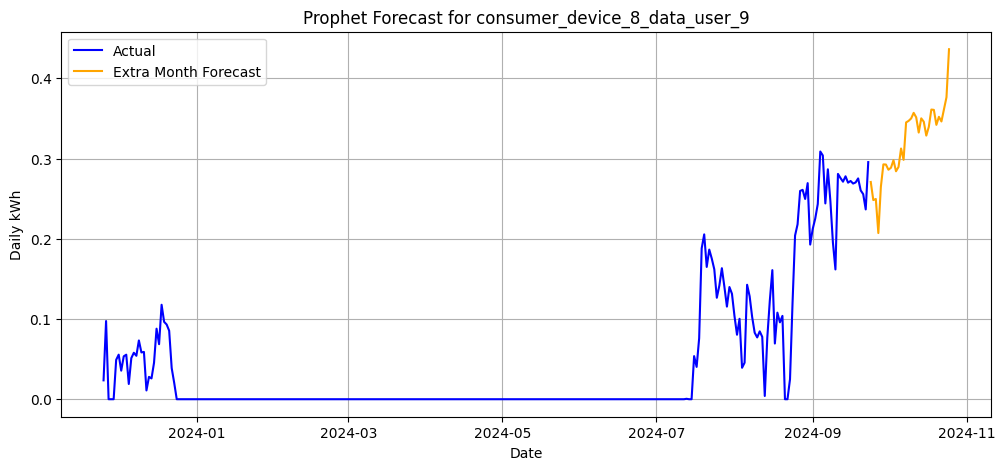

21:18:45 - cmdstanpy - INFO - Chain [1] start processing
21:18:45 - cmdstanpy - INFO - Chain [1] done processing


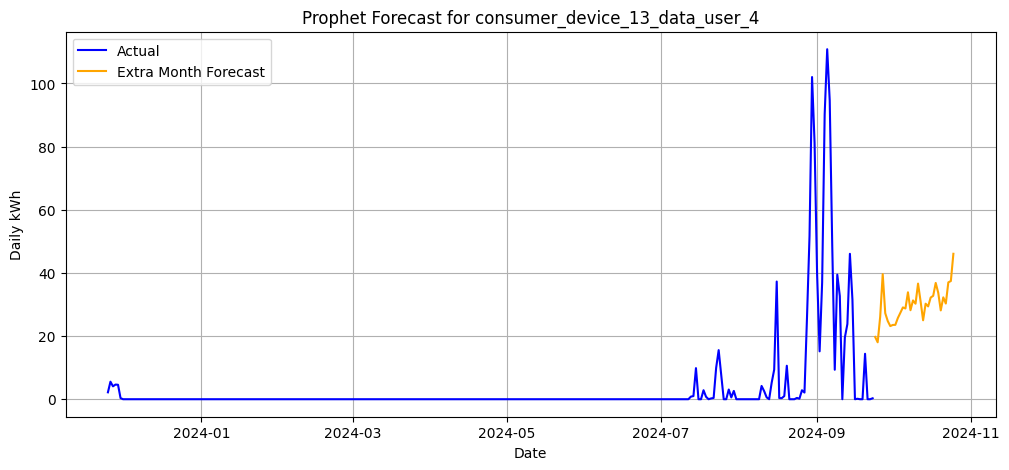

21:18:45 - cmdstanpy - INFO - Chain [1] start processing
21:18:45 - cmdstanpy - INFO - Chain [1] done processing


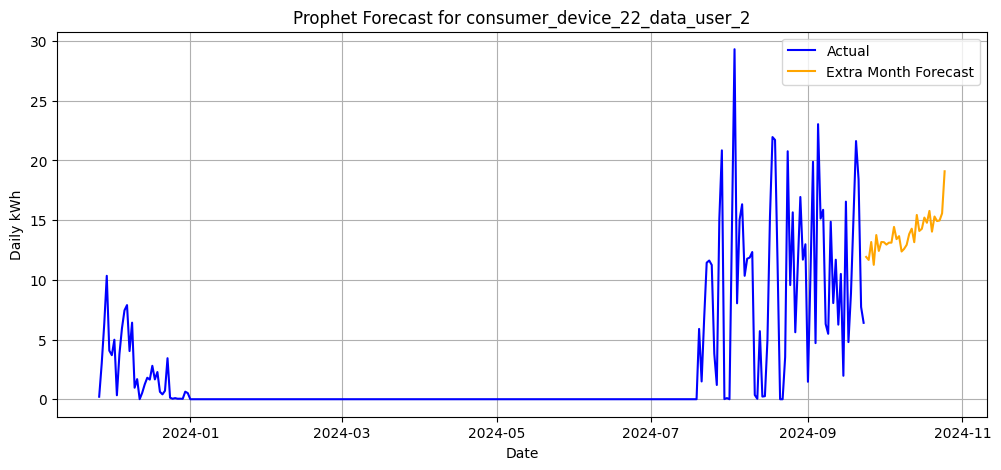

21:18:45 - cmdstanpy - INFO - Chain [1] start processing
21:18:45 - cmdstanpy - INFO - Chain [1] done processing


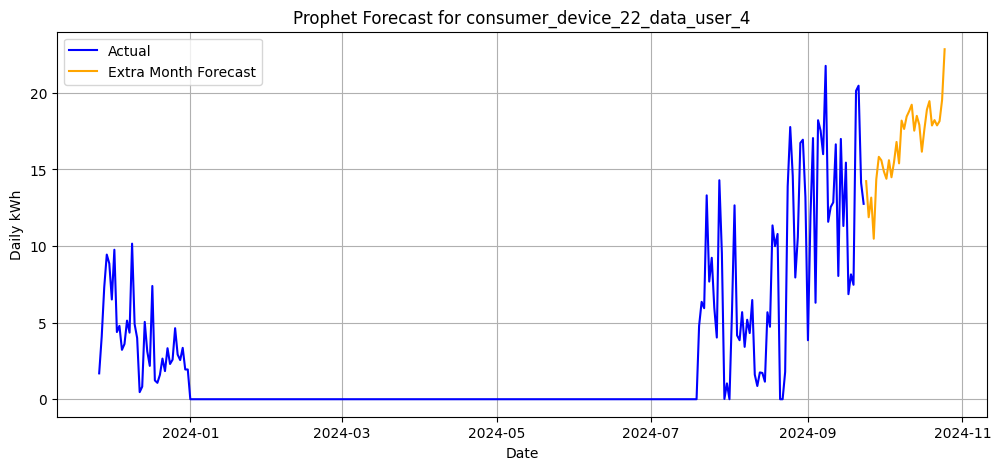

21:18:46 - cmdstanpy - INFO - Chain [1] start processing
21:18:46 - cmdstanpy - INFO - Chain [1] done processing


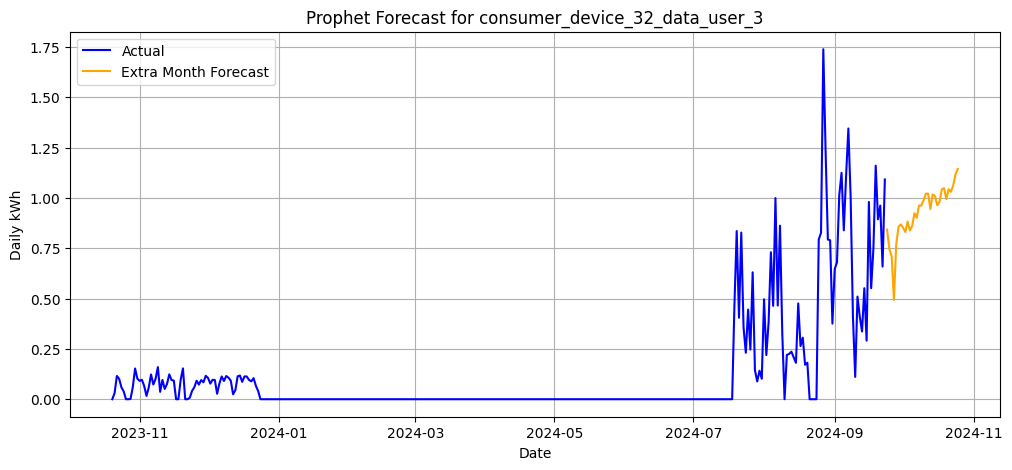

21:18:46 - cmdstanpy - INFO - Chain [1] start processing
21:18:46 - cmdstanpy - INFO - Chain [1] done processing


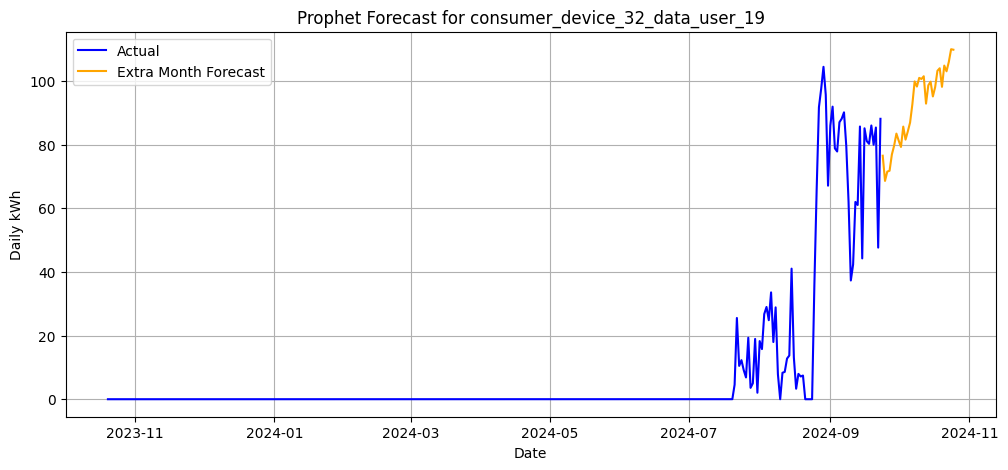

In [41]:
import matplotlib.pyplot as plt

sources = ['consumer_device_8_data_user_9', 'consumer_device_13_data_user_4',
    'consumer_device_22_data_user_2', 'consumer_device_22_data_user_4',
    'consumer_device_32_data_user_3', 'consumer_device_32_data_user_19'
]

for source in sources:
    # Historical data for this source
    df_source = df_daily_merged[df_daily_merged['Source'] == source].copy()
    df_source['date'] = pd.to_datetime(df_source['date'])
    df_source = df_source.sort_values('date')
    
    # Prepare Prophet format
    df_prophet = df_source.rename(columns={'date':'ds', 'kwh_sum':'y'})
    
    # Fit Prophet model for this source
    m = Prophet()
    for col in climate_features:
        m.add_regressor(col)
    m.fit(df_prophet[['ds','y'] + climate_features])
    
    # Prepare extra month for this source
    df_future = df_extra_month.copy()
    df_future['ds'] = pd.to_datetime(df_future['date'])
    df_future[climate_features] = df_future[climate_features].fillna(0)
    
    # Forecast extra month
    forecast_extra = m.predict(df_future[['ds'] + climate_features])
    
    # Plot historical + extra month
    plt.figure(figsize=(12,5))
    plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual', color='blue')
    plt.plot(forecast_extra['ds'], forecast_extra['yhat'], label='Extra Month Forecast', color='orange')
    plt.title(f'Prophet Forecast for {source}')
    plt.xlabel('Date')
    plt.ylabel('Daily kWh')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
'''# Ensure df_extra_month contains the extra month dates and climate features
df_extra_month['ds'] = pd.to_datetime(df_extra_month['date'])

# Get all unique sources
all_sources = df_daily_merged['Source'].unique()

submission_rows = []

for source in all_sources:
    # Historical data for this source
    df_source = df_daily_merged[df_daily_merged['Source'] == source].copy()
    df_source['date'] = pd.to_datetime(df_source['date'])
    df_source = df_source.sort_values('date')
    
    # Use last known kWh as lag1 for the future
    last_kwh = df_source['kwh_sum'].iloc[-1]
    
    # Prepare future dataframe
    df_future = df_extra_month.copy()
    df_future['kwh_sum_lag1'] = last_kwh
    
    # Fill missing climate features if any
    df_future[climate_features] = df_future[climate_features].fillna(0)
    
    # Predict using trained Prophet model
    predictors = ['ds'] + climate_features + ['kwh_sum_lag1']
    forecast_extra = m.predict(df_future[predictors])
    df_future.to_csv('models/prophet_future_features.csv', index=False)
    
    # Build submission rows
    for ds, yhat in zip(forecast_extra['ds'], forecast_extra['yhat']):
        submission_rows.append({
            'ID': f"{ds.date()}_{source}",
            'kwh': round(yhat, 2)
        })

# Create submission DataFrame
submission_df = pd.DataFrame(submission_rows)

# Save to CSV
submission_df.to_csv('prophet_submission_all_sources)new.csv', index=False)
print("Submission file saved as prophet_submission_all_sources_new.csv")'''


Submission file saved as prophet_submission_all_sources.csv
